In [5]:
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import layers, models


In [2]:
# Cargar dataset
base_images_dir = Path("../Dataset_emocional")

if not base_images_dir.exists():
    raise FileNotFoundError(f"No se encontró: {base_images_dir.resolve()}")

print(f"✓ Dataset encontrado en: {base_images_dir.resolve()}")

# Crear datasets
ORIGINAL_IMG_SIZE = (28, 28)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    str(base_images_dir),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'
)

val_ds = keras.utils.image_dataset_from_directory(
    str(base_images_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"✓ Clases: {class_names}")
print(f"✓ Número de clases: {num_classes}")

# Optimizar datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

✓ Dataset encontrado en: C:\Users\cance\Documents\GitHub\Sentimental_emoji_classifier\Dataset_emocional
Found 600 files belonging to 3 classes.
Using 480 files for training.
Found 600 files belonging to 3 classes.
Using 120 files for validation.
✓ Clases: ['Enojado', 'Feliz', 'Triste']
✓ Número de clases: 3


In [3]:
# Normalizar datos
train_ds_normalized = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds_normalized = val_ds.map(lambda x, y: (x / 255.0, y))

print("✓ Datasets normalizados")

✓ Datasets normalizados


In [6]:
# Construir CNN desde cero
cnn_model = models.Sequential([
    # Capa convolucional 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    # Capa convolucional 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Capa convolucional 3
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Capas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

print("✓ Modelo CNN creado")
cnn_model.summary()

✓ Modelo CNN creado


c:\Users\cance\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,987 (507.76 KB)

 Trainable params: 129,987 (507.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compilar modelo
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Modelo compilado")

✓ Modelo compilado


In [8]:
# Entrenar modelo
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

epochs = 100

history = cnn_model.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

print("\n✓ Entrenamiento completado")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3417 - loss: 1.1106 - val_accuracy: 0.3750 - val_loss: 1.0909
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3417 - loss: 1.1106 - val_accuracy: 0.3750 - val_loss: 1.0909
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3458 - loss: 1.0917 - val_accuracy: 0.5167 - val_loss: 1.0846
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3458 - loss: 1.0917 - val_accuracy: 0.5167 - val_loss: 1.0846
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4667 - loss: 1.0658 - val_accuracy: 0.4500 - val_loss: 1.0615
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4667 - loss: 1.0658 - val_accuracy: 0.4500 - val_loss: 1.0615
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4542 - loss: 1.0424 - val_accuracy: 0.5833 - val_loss: 1.0018
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4542 - loss: 1.0424 - val_accuracy: 0.5833 -

In [9]:
# Guardar modelo
cnn_model.save("cnn_model_emociones.h5")
print("✓ Modelo guardado como 'cnn_model_emociones.h5'")

✓ Modelo guardado como 'cnn_model_emociones.h5'


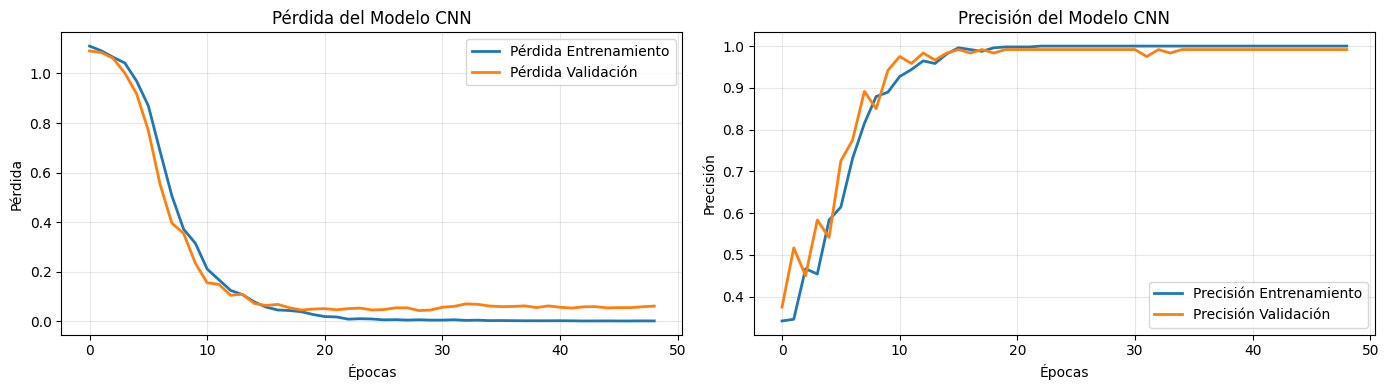

Épocas entrenadas: 49
Precisión final validación: 0.9917


In [10]:
# Gráficos de entrenamiento
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Pérdida Entrenamiento', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Pérdida Validación', linewidth=2)
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')
axes[0].set_title('Pérdida del Modelo CNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Precisión Entrenamiento', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Precisión Validación', linewidth=2)
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')
axes[1].set_title('Precisión del Modelo CNN')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Épocas entrenadas: {len(history.history['loss'])}")
print(f"Precisión final validación: {history.history['val_accuracy'][-1]:.4f}")

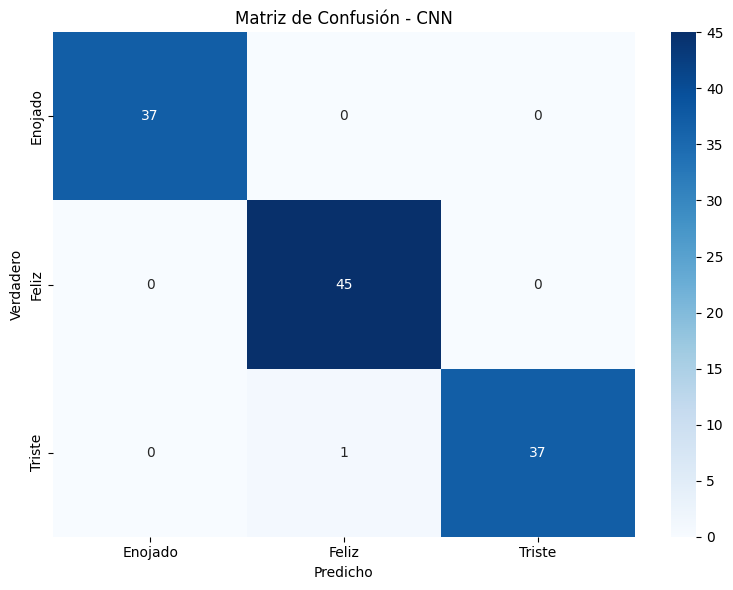


Reporte de Clasificación:
              precision    recall  f1-score   support

     Enojado       1.00      1.00      1.00        37
       Feliz       0.98      1.00      0.99        45
      Triste       1.00      0.97      0.99        38

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [11]:
# Evaluar en validación
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for x_batch, y_batch in val_ds_normalized:
    predictions = cnn_model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - CNN')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

✓ Imagen: a55db0c26ab25cc08b6b875719df3533.jpg


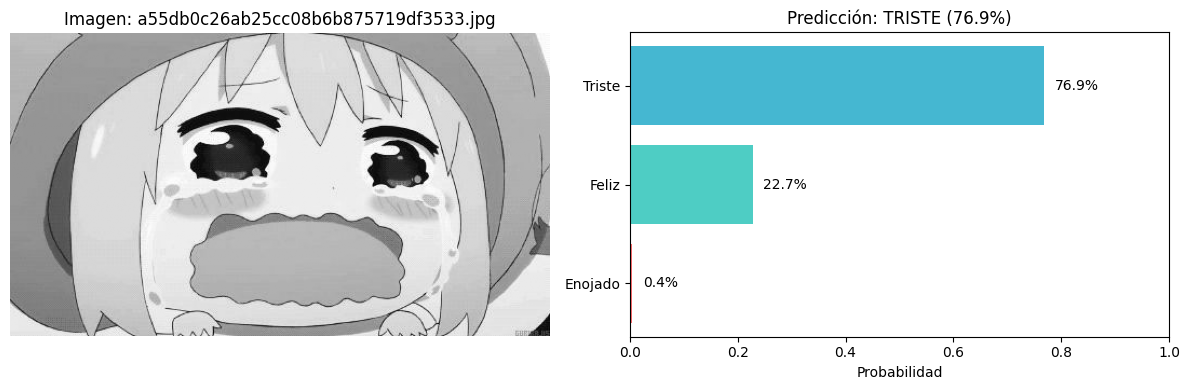


✓ Predicción: TRISTE
Confianza: 76.85%


In [16]:
# Prueba con nueva imagen
from PIL import Image

image_path = "C:/Users/cance/Downloads/a55db0c26ab25cc08b6b875719df3533.jpg"  # Cambiar por tu imagen
image_path = Path(image_path)

if not image_path.exists():
    print(f"❌ No se encontró: {image_path}")
else:
    print(f"✓ Imagen: {image_path.name}")
    
    # Procesar
    img = Image.open(image_path).convert('L')
    img_resized = img.resize((28, 28))
    img_array = np.array(img_resized) / 255.0
    img_input = img_array.reshape(1, 28, 28, 1)
    
    # Predicción
    prediction = cnn_model.predict(img_input, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title(f"Imagen: {image_path.name}")
    axes[0].axis('off')
    
    probabilities = prediction[0]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    axes[1].barh(class_names, probabilities, color=colors)
    axes[1].set_xlabel('Probabilidad')
    axes[1].set_title(f'Predicción: {class_names[predicted_class].upper()} ({confidence*100:.1f}%)')
    axes[1].set_xlim([0, 1])
    
    for i, (emotion, prob) in enumerate(zip(class_names, probabilities)):
        axes[1].text(prob + 0.02, i, f'{prob*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Predicción: {class_names[predicted_class].upper()}")
    print(f"Confianza: {confidence*100:.2f}%")